# Time Series EDA

What is it?
- multiple different visualizations for exploring time series data

Why do we care?
- allows us to identify trend and seasonality

#### Topics
- Time Series Train-Test Split
    - Cross Validate Splits
    - Percentage Based
    - Human-based


- 10 Weird Time Series Visualizations to Impress Your Friends and Family
    1. Blow off the time series
    1. Target over time
    1. Target averaged over various periods over time
    1. Change in target over time
    1. Seasonal Plot
    1. Seasonal Subseries Plot
    1. Lag Plot
    1. Autocorrelation Plot
    1. Seasonal Decomposition
    1. Area Plots
    
    
- Aside: working with dates in matplotlib
- Aside: `strftime`

In [164]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(10, 5))
# plt.rc('font', size=12)

Scenario: We'll be looking at temperature data for san antonio from late 2012 to late 2017.



In [253]:
url = 'https://gist.githubusercontent.com/ryanorsinger/\
0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv'
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()

In [167]:
df.head()

,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747


We'll need to convert from Kelvin to Fahrenheit.

        °F = (K - 273.15) x 1.8000 + 32.00

In [168]:
# converting the units of the data we are ingesting
df.temp = (df.temp - 273.15) * 1.8 + 32

In [169]:
df.head()

,temp
datetime,
2012-10-01 13:00:00,-349.776400
2012-10-01 14:00:00,-349.732178
2012-10-01 15:00:00,-349.619271
2012-10-01 16:00:00,-349.506363
2012-10-01 17:00:00,-349.393456


In [170]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00


In [171]:
df.shape

(45252, 1)

## Data Splitting

**seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality

**trend**: long term upwards or downwards movement

**cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

Ideally all splits contain a season

- Cross-validation-based: Break data into slices and use successive slices as train and test repeatedly
- Percentage-based: A cutoff is selected arbitrarily (ex: use the last 20% of observations as Test)
- Human-based: Using domain knowledge, a cutoff is selected. (ex: use the last year as Test)

### Cross-validation-based

`sklearn.model_selection.TimeSeriesSplit`

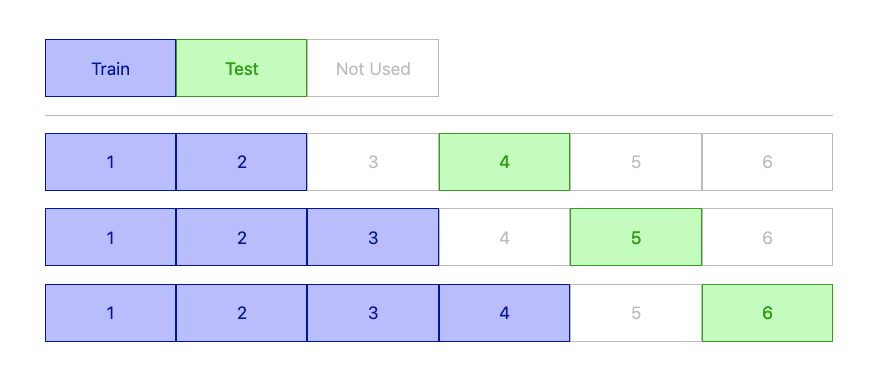

### Percentage-Based

We will set a percentage of our data to use as the train. 

In [210]:
train_size = 0.70 
n = df.shape[0] 
test_start_index = round(train_size * n) 

In [211]:
train = df.iloc[:test_start_index] 
test = df.iloc[test_start_index:] 

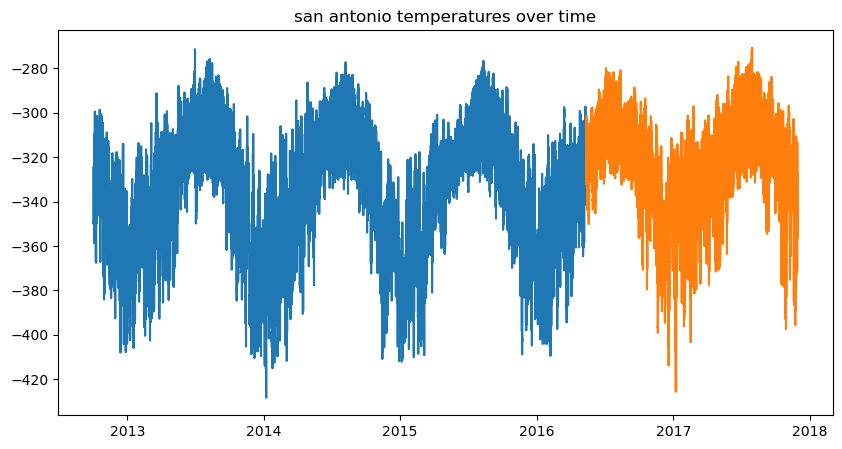

In [212]:
plt.plot(train.temp)
plt.plot(test.temp)
plt.title('san antonio temperatures over time')
plt.show()

### Human-Based

We will be splitting based on our human knowledge! 

In [213]:
train = df.loc[:'2016'].copy()
test = df.loc['2017'].copy()

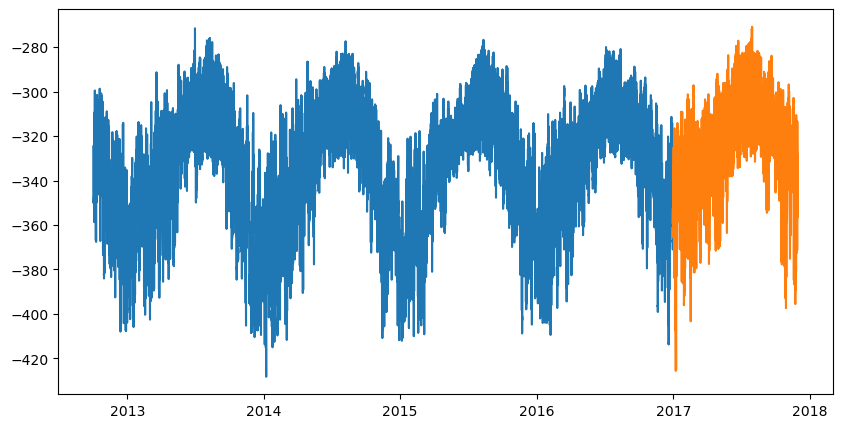

In [214]:
plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)
plt.show()

## Visualizations

My target variable is the temperture

In [215]:
y = train.temp
y.head()

datetime
2012-10-01 13:00:00   -349.776400
2012-10-01 14:00:00   -349.732178
2012-10-01 15:00:00   -349.619271
2012-10-01 16:00:00   -349.506363
2012-10-01 17:00:00   -349.393456
Name: temp, dtype: float64

### 1. Blow off the time series

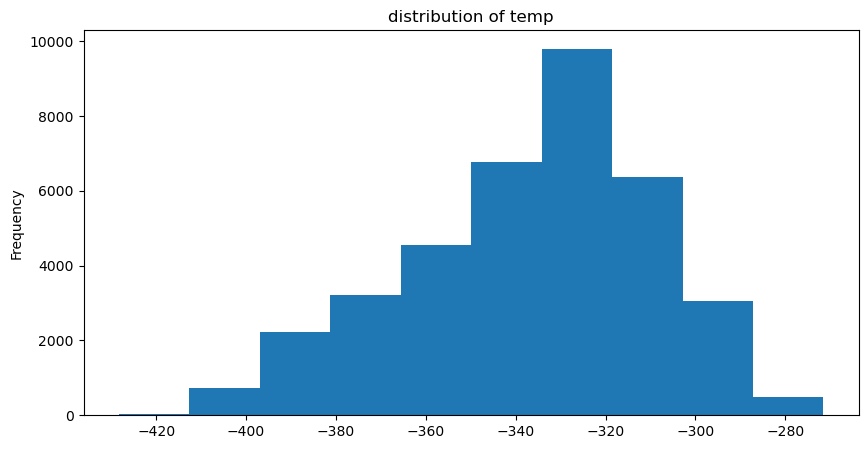

In [216]:
train.temp.plot.hist()
plt.title('distribution of temp')
plt.show()

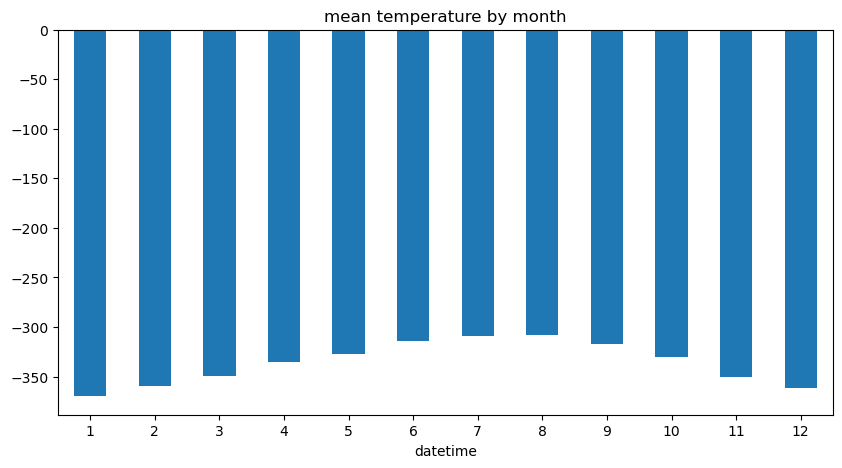

In [217]:
train.groupby(train.index.month).temp.mean()\
.plot.bar().tick_params('x', rotation=0)

plt.title('mean temperature by month')
plt.show()

In [218]:
# assign a weekday column from the day_name() method on the datetime index
train['weekday'] = train.index.day_name()
train['day_num'] = train.index.day_of_week

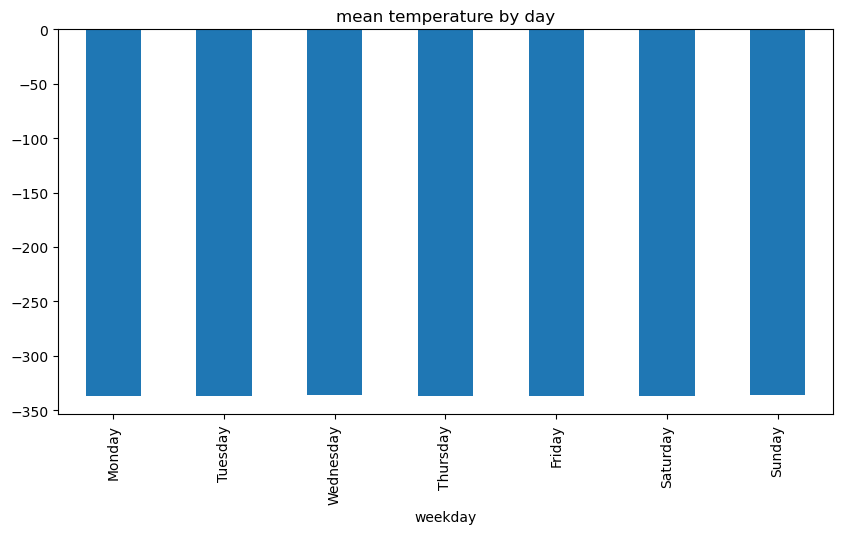

In [219]:
# aggregate on that weekday
train.groupby('weekday').mean().sort_values('day_num').temp.plot.bar()

plt.title('mean temperature by day')
plt.show()

### 2. target over time

In [220]:
train.columns

Index(['temp', 'weekday', 'day_num'], dtype='object')

In [221]:
y.head()

datetime
2012-10-01 13:00:00   -349.776400
2012-10-01 14:00:00   -349.732178
2012-10-01 15:00:00   -349.619271
2012-10-01 16:00:00   -349.506363
2012-10-01 17:00:00   -349.393456
Name: temp, dtype: float64

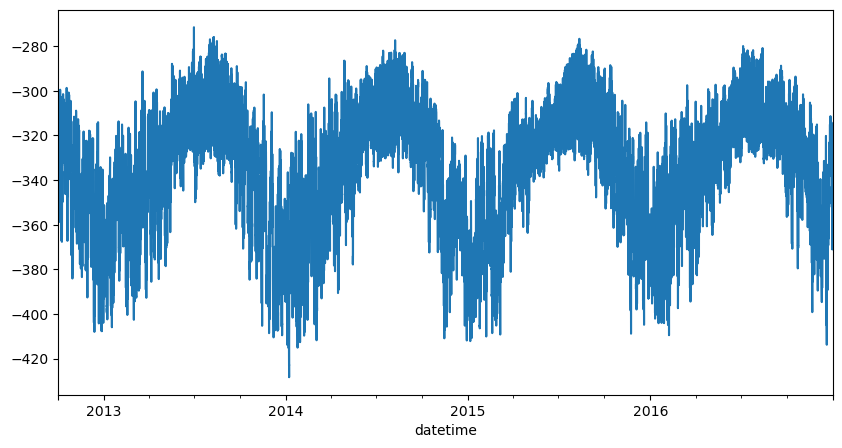

In [222]:
y.plot();

### 3. target averaged over various periods over time

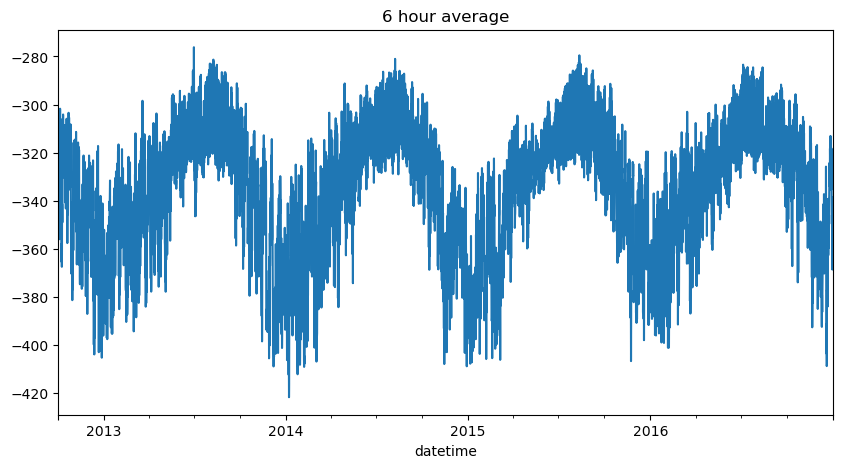

In [223]:
y.resample('6H').mean().plot(title='6 hour average');

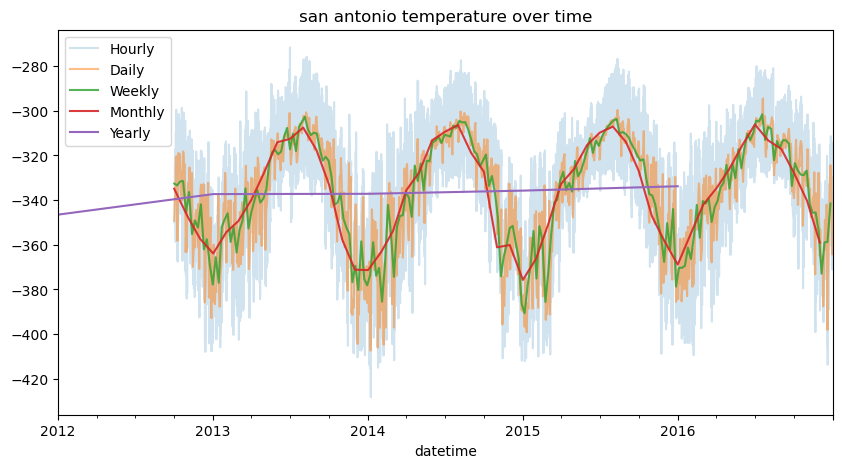

In [224]:
y.plot(alpha=0.2, label='Hourly')

y.resample('D').mean().plot(alpha=0.5, label='Daily')
y.resample('W').mean().plot(alpha=0.8, label='Weekly')
y.resample('M').mean().plot(alpha=0.9, label='Monthly')
y.resample('Y').mean().plot(label='Yearly')

plt.title('san antonio temperature over time')
plt.legend()
plt.show()

### 4. change in target over time

.diff will allow us to get deltas between values

#### look at the difference in data by week
- resample the data by week, get the average for that week
- make the difference utilizing .diff()
- plot the changes over time in order to examine volatility

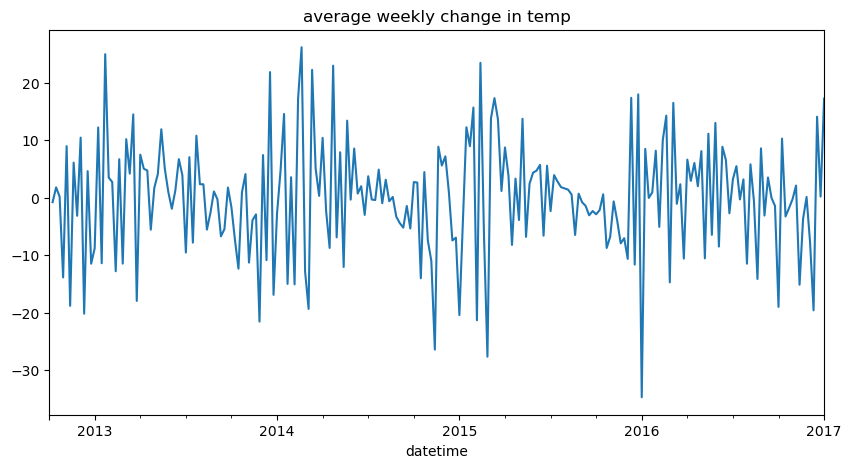

In [225]:
y.resample('W').mean().diff().plot(title='average weekly change in temp');

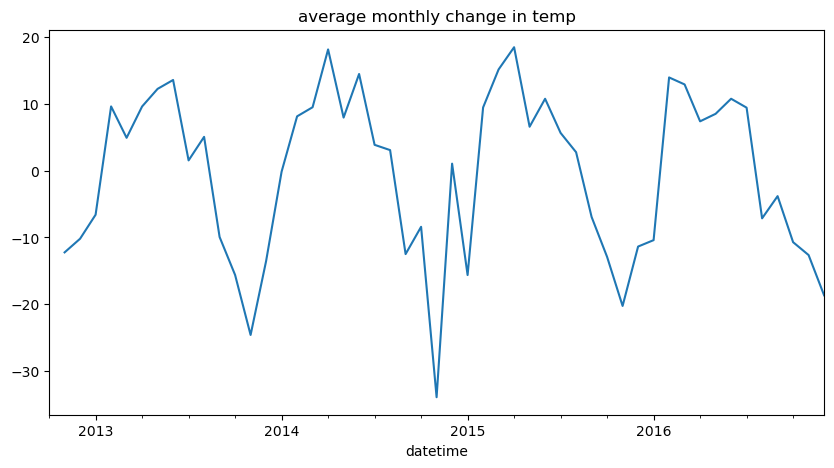

In [226]:
y.resample('M').mean().diff().plot(title='average monthly change in temp');

### 5. Seasonal Plot

shows the comparison of multiple seasons together

our example: one season is one year. multiple lines are shown to show multiple years.

- xaxis: month 
- yaxis: y
- color: year

In [227]:
y.groupby([y.index.year, y.index.month]).mean()[:6]

datetime  datetime
2012      10         -334.896332
          11         -347.131165
          12         -357.321975
2013      1          -363.923800
          2          -354.328961
          3          -349.429938
Name: temp, dtype: float64

#### `.unstack`
- unstack will make a pivot table of a second order index

In [228]:
y.groupby([y.index.year, y.index.month]).mean().unstack()

datetime,1,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-334.896332,-347.131165,-357.321975
2013,-363.923800,-354.328961,-349.429938,-339.844509,-327.624648,-314.075690,-312.552725,-307.508590,-317.439750,-333.051103,-357.635150,-371.172441
2014,-371.338786,-363.227655,-353.753574,-335.633920,-327.708455,-313.262215,-309.411624,-306.349416,-318.840482,-327.248946,-361.145288,-360.108716
2015,-375.732508,-366.295571,-351.170131,-332.721617,-326.164456,-315.425260,-309.794216,-307.048254,-313.981226,-326.890361,-347.135474,-358.497188
2016,-368.900776,-354.971652,-342.088580,-334.722432,-326.236396,-315.494374,-306.083848,-313.227359,-317.049743,-327.757382,-340.392915,-359.044196


In [229]:
# In this case, we turn the 0 index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0)

datetime,2012,2013,2014,2015,2016
datetime,,,,,
1,NaN,-363.923800,-371.338786,-375.732508,-368.900776
2,NaN,-354.328961,-363.227655,-366.295571,-354.971652
3,NaN,-349.429938,-353.753574,-351.170131,-342.088580
4,NaN,-339.844509,-335.633920,-332.721617,-334.722432
5,NaN,-327.624648,-327.708455,-326.164456,-326.236396
6,NaN,-314.075690,-313.262215,-315.425260,-315.494374
7,NaN,-312.552725,-309.411624,-309.794216,-306.083848
8,NaN,-307.508590,-306.349416,-307.048254,-313.227359
9,NaN,-317.439750,-318.840482,-313.981226,-317.049743


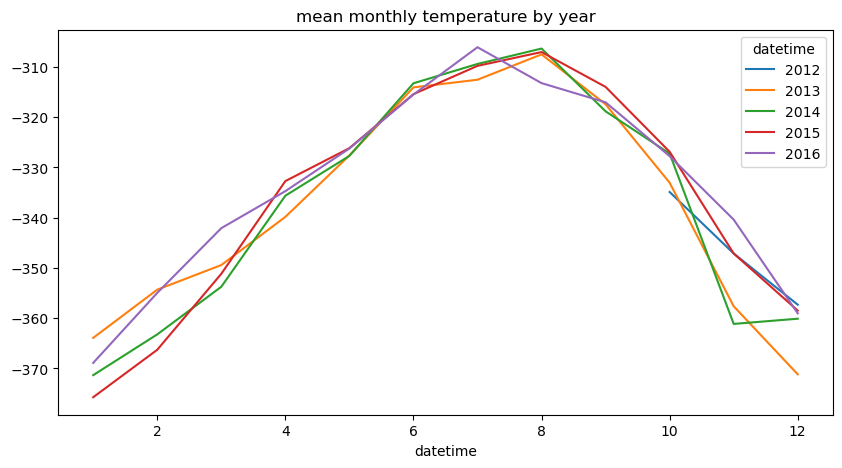

In [230]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot()
plt.title('mean monthly temperature by year')
plt.show()

### 6. Seasonal Subseries Plot

In [231]:
# make my pivot table of years to month with unstack()
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table

datetime,1,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-334.896332,-347.131165,-357.321975
2013,-363.923800,-354.328961,-349.429938,-339.844509,-327.624648,-314.075690,-312.552725,-307.508590,-317.439750,-333.051103,-357.635150,-371.172441
2014,-371.338786,-363.227655,-353.753574,-335.633920,-327.708455,-313.262215,-309.411624,-306.349416,-318.840482,-327.248946,-361.145288,-360.108716
2015,-375.732508,-366.295571,-351.170131,-332.721617,-326.164456,-315.425260,-309.794216,-307.048254,-313.981226,-326.890361,-347.135474,-358.497188
2016,-368.900776,-354.971652,-342.088580,-334.722432,-326.236396,-315.494374,-306.083848,-313.227359,-317.049743,-327.757382,-340.392915,-359.044196


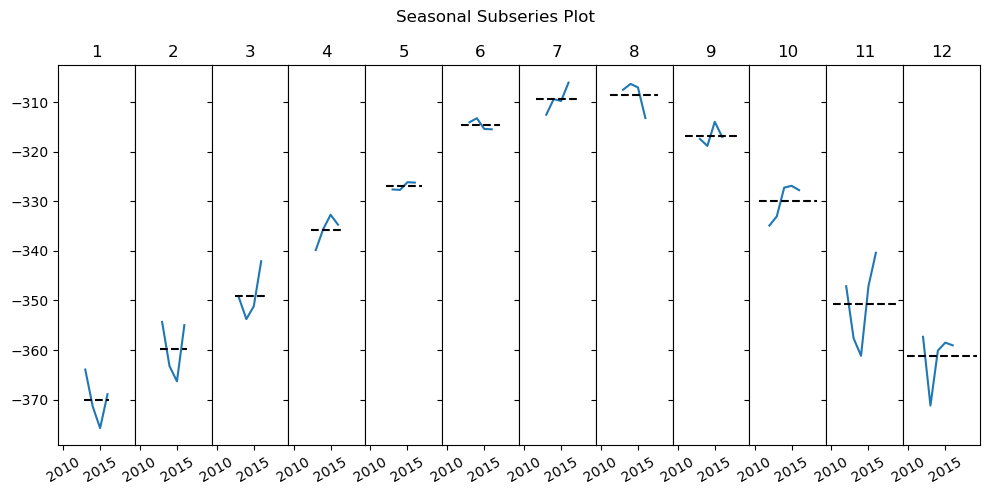

In [232]:
# unpacking my figure and axes elements
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)

# for ax, (month, subset) 
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim(), color='black', ls='--')
    ax.set(xlabel='')
    ax.tick_params('x', rotation=30)
    
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.tight_layout()
fig.subplots_adjust(wspace=0)

As with the monthly box plot, the seasonal pattern is quite evident in the seasonal subseries.
- Do the data exhibit a seasonal pattern?
- What is the nature of the seasonality?
- Is there a within-group pattern (e.g., do January and July exhibit similar patterns)?
- Are there any outliers once seasonality has been accounted for?

### 7. Lag Plot

A lag plot is a scatter plot of a series with itself, shifted, or lagged. Put another way, a lag plot measures one value against the next or previous value.

If your data is sampled daily, you could think of t as 'today', t+1 is 'tomorrow'. More generally, t is any given time period and t+1 is the time period after. If your data is sampled weekly, t is any given week, and t+1 is the following week.

In [233]:
train['y(t + 1)'] = train.temp.shift(-1)
train.head()

,temp,weekday,day_num,y(t + 1)
datetime,,,,
2012-10-01 13:00:00,-349.776400,Monday,0,-349.732178
2012-10-01 14:00:00,-349.732178,Monday,0,-349.619271
2012-10-01 15:00:00,-349.619271,Monday,0,-349.506363
2012-10-01 16:00:00,-349.506363,Monday,0,-349.393456
2012-10-01 17:00:00,-349.393456,Monday,0,-349.280548


/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


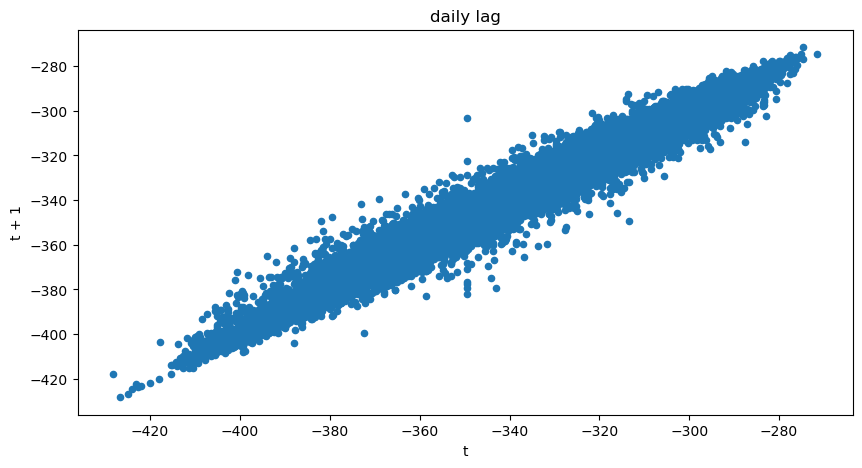

In [234]:
train.plot.scatter(x='temp', y='y(t + 1)').set(xlabel='t', ylabel='t + 1')
plt.title('daily lag')
plt.show()

looks like we have a pretty strong linear association between the hour now and the temperature for the next hour

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


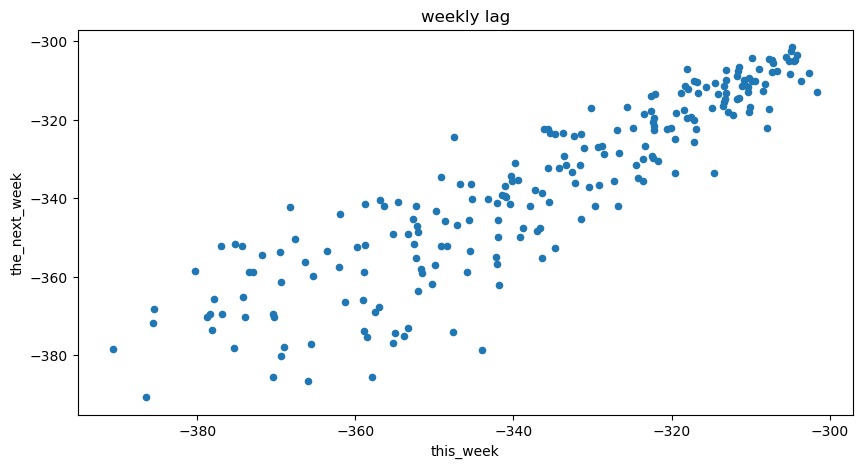

In [235]:
weekly = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
plt.title('weekly lag')
plt.show()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


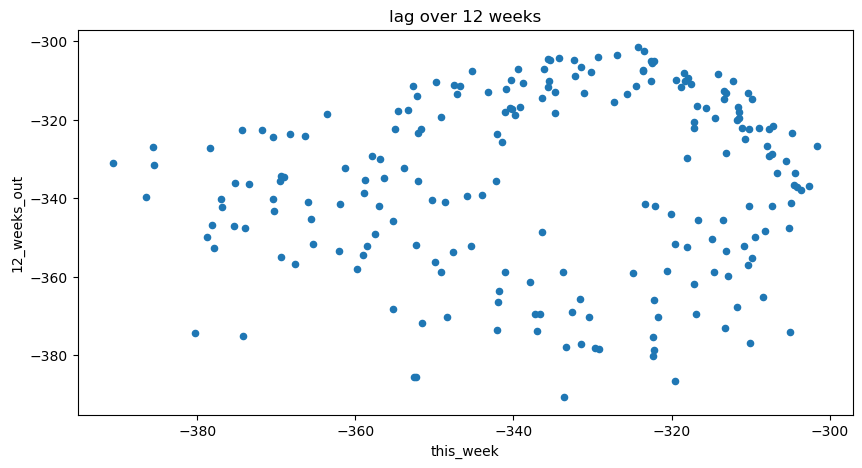

In [236]:
weekly  = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['12_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
plt.title('lag over 12 weeks')
plt.show()

#### use `pd.plotting.lag_plot` 

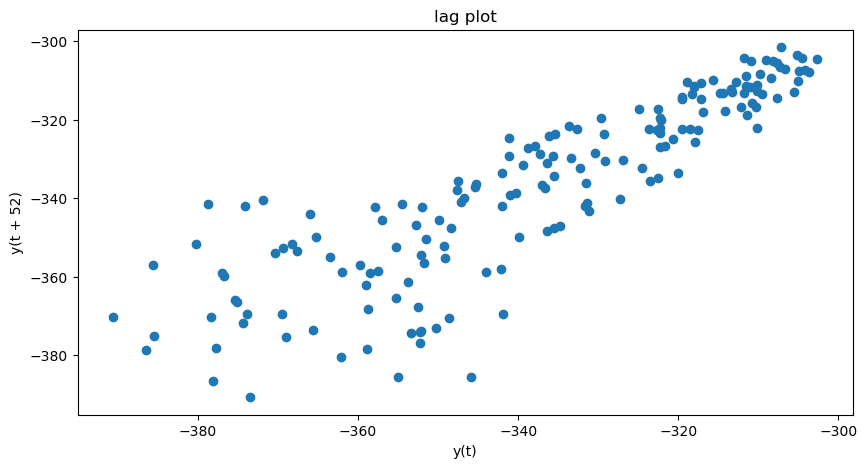

In [237]:
#same thing, but easier
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=52)
plt.title('lag plot');

### 8. Autocorrelation Plot

**Autocorrelation** is a measure of the linear relationship between lagged values of a time series. An autocorrelation plot shows the correlation coefficient as a function of lag time.

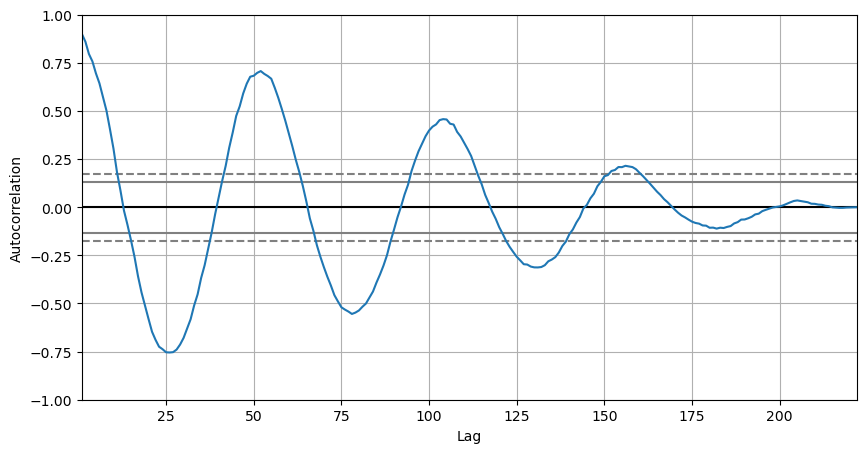

In [238]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())
plt.show()

This can help us identify seasonality by looking at the peaks and valleys of the resulting visualization. The peaks can tells us the frequency with which the seasonality repeats itself, and the valleys show us where the correlation is the most negative.

The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise.

### 9. Seasonal Decomposition

Seasonal decomposition is a fancy way to say that we can model time series as having 3 seperate components, the seasonal repeated cycle, the long term trend, and random noise1. There are two types of seasonal decomposition models, additive and multiplicative.

#### data = Seasonality + Trend + Residual

In [239]:
import statsmodels.api as sm

In [240]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)

In [241]:
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid
})

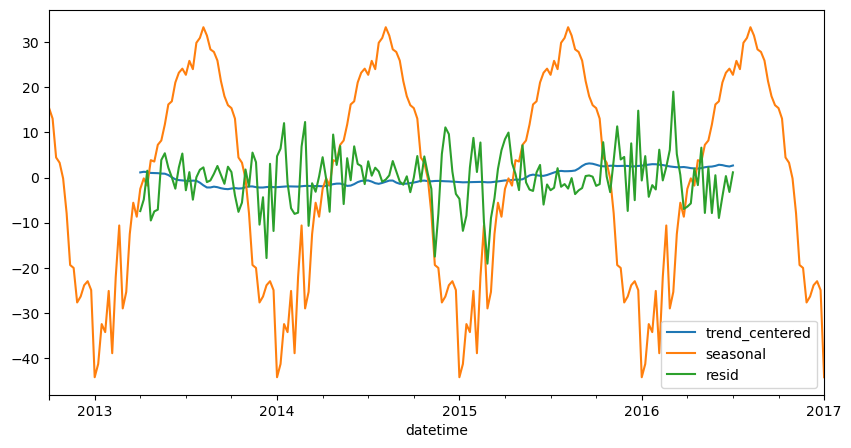

In [242]:
decomposition['trend_centered'] = decomposition.trend - decomposition.trend.mean()
decomposition[['trend_centered', 'seasonal', 'resid']].plot();

### 10 Area Plots

- can we visualize categories over time?

In [243]:
train.columns

Index(['temp', 'weekday', 'day_num', 'y(t + 1)'], dtype='object')

In [244]:
train = train.drop(columns=['y(t + 1)','weekday','day_num'])
train = train.resample('D').mean()
train

,temp
datetime,
2012-10-01,-349.274304
2012-10-02,-341.448120
2012-10-03,-338.329750
2012-10-04,-337.803250
2012-10-05,-320.938375
...,...
2016-12-27,-329.109250
2016-12-28,-329.585800
2016-12-29,-344.009200


In [245]:
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])

In [246]:
train.head()

,temp,temp_bin
datetime,,
2012-10-01,-349.274304,cool
2012-10-02,-341.448120,cool
2012-10-03,-338.329750,cool
2012-10-04,-337.803250,cool
2012-10-05,-320.938375,warm


In [247]:
train.groupby('temp_bin').resample('M').size()

temp_bin  datetime  
cold      2012-10-31     6
          2012-11-30    10
          2012-12-31    16
          2013-01-31    24
          2013-02-28    17
                        ..
hot       2016-06-30    19
          2016-07-31    28
          2016-08-31    21
          2016-09-30    18
          2016-10-31     5
Length: 195, dtype: int64

How is the distribution of temp_bin changing over time?

In [248]:
train.groupby('temp_bin').mean()

,temp
temp_bin,
cold,-370.782942
cool,-342.309605
warm,-323.863642
hot,-309.461643


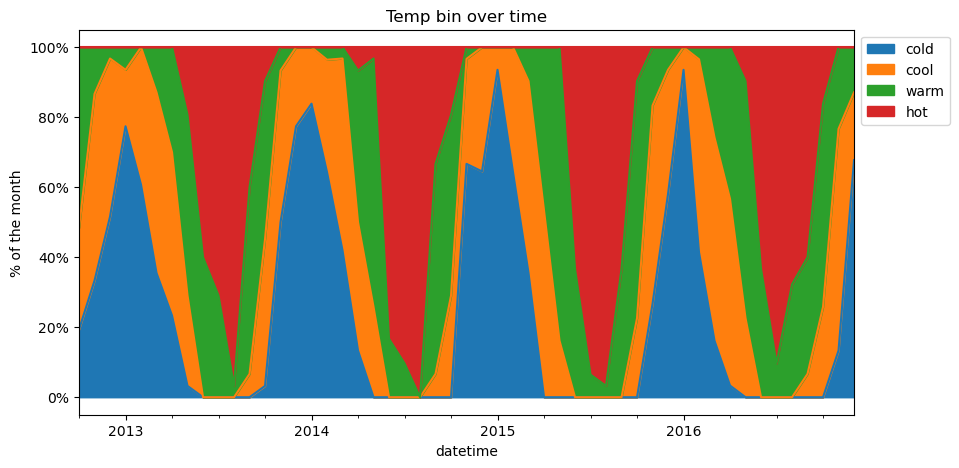

In [252]:
ax = (train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area(title='Temp bin over time', ylabel='% of the month'))
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter('{:.0%}'.format)